In [1]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.model_selection import train_test_split
import random

import pathlib
import librosa
import matplotlib.pyplot as plt
import librosa.display
import seaborn as sns



2022-10-02 20:49:44.513094: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-02 20:49:44.692124: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-02 20:49:45.399244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-10-02 20:49:45.399337: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Coul

In [2]:
TF_ENABLE_ONEDNN_OPTS=0

In [3]:
import numpy as np
import IPython
T = 2.0    # seconds
sr = 22050  # sample rate
t = np.linspace(0, T, int(T*sr), endpoint=False)  # time variable
x = 0.5*np.sin(2*np.pi*440*t)                # pure sine wave at 440 Hz
IPython.display.Audio(x, rate=sr)


## initial

In [4]:
ori_data_path = '/home/angel00540/work_/work/cgh_2022/exp/siamese_network/data/child/'
DATE = "0327word"
npz_save_path = '/home/angel00540/work_/work/cgh_2022/exp/binear_classification/npzdata/Stoping-error/'+DATE+'/'
SUBJET = 'child'
if not os.path.exists(npz_save_path):
    os.makedirs(npz_save_path)

npz_name = 'siamese_0_1_data'+DATE+'_'+SUBJET

SEED = 42
KFOLD = True
K = 3
random.seed(SEED)

## make Dataset

In [5]:
classes=[]

def load_class():
    for _, dirs, _ in os.walk(os.path.abspath(ori_data_path)):
        break
    dirs = [int(x) for x in dirs]
    dirs.sort()
    dirs = [str(x) for x in dirs]
    return dirs

classes=load_class()
print(classes)

['1', '5', '13', '16']


In [6]:
def wordcardNumber(filePath):
    filePath = os.path.splitext(filePath)[0]
    index = filePath.index(filePath.split('_')[2])
    return "wordcard"+filePath[index:]


In [7]:
filePaths = []
tmp_label = []
wordcardList =[] 
for n in classes:
    ori_path = ori_data_path + str(n)+'/'
    ori_n = 0
    for root2, _, files2 in os.walk(os.path.abspath(ori_path)):
        for file2 in files2:
            if('wav' in file2):
                wordcardList.append(wordcardNumber(file2))
                # print(file2.index(file2.split('_')[1]))
                filePaths.append(os.path.join(root2, file2))
                tmp_label.append(n)
                ori_n = ori_n+1
    print('Class: ', n, ' files: ',ori_n)
# random.Random(SEED).shuffle(file_path)  # 把tmp_list弄亂


Class:  1  files:  177
Class:  5  files:  168
Class:  13  files:  80
Class:  16  files:  931


#### librosa

In [8]:
from IPython.display import Audio

def prinitSpecshow(spectrogram, hop_length):
    fig, ax = plt.subplots()
    img = librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),
                                   y_axis='log', x_axis='time', hop_length=frame_step, ax=ax)
    ax.set_title('Power spectrogram')
    fig.colorbar(img, ax=ax, format="%+2.0f dB")

    # D = librosa.amplitude_to_db(spectrogram, ref=np.max)

    # plt.subplot(4, 2, 1)
    # librosa.display.specshow(D, y_axis='linear')
    # plt.colorbar(format='%+2.0f dB')
    # plt.title('Linear-frequency power spectrogram')


def plot_time_series(data, sr):
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, len(data)/sr, len(data)), data)
    plt.show()




sr:16000


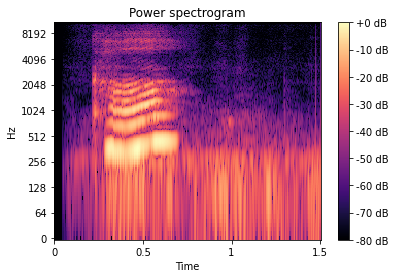

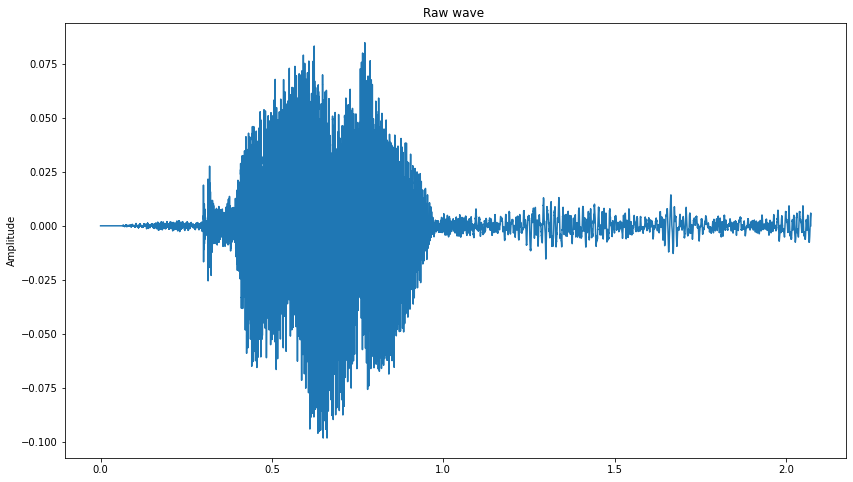

In [9]:
import matplotlib.pyplot as plt
import librosa
# An integer scalar Tensor. The window length in samples.
frame_length = 255
# An integer scalar Tensor. The number of samples to step.
frame_step = 128
# An integer scalar Tensor. The size of the FFT to apply.


y, sr = librosa.load(filePaths[184], sr=16000)
# print(f"y.shape:{y.shape}")
print(f"sr:{sr}")
spectrogram = librosa.stft(y, hop_length=frame_step,win_length=frame_length)
# print(f"spectrogram.shape:{spectrogram.shape}")

spectrogram = np.abs(spectrogram)

# spectrogram = np.power(spectrogram, 0.5)

# means = np.mean(spectrogram, 0, keepdims=True)
# stddevs = np.std(spectrogram, 0, keepdims=True)
# spectrogram = (spectrogram - means) / (stddevs + 1e-10)
prinitSpecshow(spectrogram, frame_step)
plot_time_series(y,sr)
Audio(y, rate=sr)


## stat sec

In [11]:
tmp_sec_lists = []
for i, filePath in enumerate(filePaths):
    try:
        y, sr = librosa.load(filePath, sr=16000)
    except:
        print("read error: ", filePath)
    if len(y) <= 0:
        break
    else:
        tmp_sec_lists.append(len(y)/sr)
    

In [12]:
filePaths[0]

'/home/angel00540/work_/work/cgh_2022/exp/siamese_network/data/child/1/1_1561261885_04_07.wav'

In [13]:
import pandas as pd
s = pd.Series(tmp_sec_lists)
s.describe()


count    1356.000000
mean        1.921497
std         0.344000
min         0.690813
25%         2.072437
50%         2.072437
75%         2.072437
max         2.275562
dtype: float64

In [10]:
wav_data = []
fix_n_sec = 2
mini_sec = 0.5
wav_label = []


for i, filePath in enumerate(filePaths):
    try:
        y, sr = librosa.load(filePath,sr =16000)
    except:
        print("read error: ", filePath)
    if len(y)<=0:
        break;
    if len(y)/sr < mini_sec:
        print('len < '+mini_sec+': ', filePath)
        break;
    if len(y)/sr > fix_n_sec:  # pad if len less 1 sec
        x = y[:fix_n_sec * sr]
    elif mini_sec < len(y)/sr < fix_n_sec :
        z = int(fix_n_sec*sr - len(y))
        if(z%2==0):
            z1 = int(z/2)
            z2 = int(z/2)
        else:
            z1 = int((z-1)/2)
            z2 = int(z1 + 1)
        try:
            # x = np.pad(y,(z1,z2), 'linear_ramp', end_values=(0, 0))
            x = np.pad(y, (z1, z2), 'constant', constant_values=(0, 0))
        except:
            print("pad error: ", filePath)
    wav_data.append(x)
    wav_label.append(tmp_label[i])
X = np.asarray(wav_data)
y = np.asarray(wav_label)
wordcard = np.asarray(wordcardList)


In [11]:
# print(f"wav_data.shape: {wav_data.shape}")
print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")
print(f"wordcard.shape: {wordcard.shape}")


X.shape: (1356, 32000)
y.shape: (1356,)
wordcard.shape: (1356,)


In [12]:
order = np.arange(len(y))
np.random.seed(SEED)
np.random.shuffle(order)
X = X[order]
y = y[order]
wordcard = wordcard[order]

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_index, test_index in sss.split(X, y):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    wordcard_train, wordcard_test = wordcard[train_index], wordcard[test_index]


In [14]:
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")


X_train.shape: (1084, 32000)
X_test.shape: (272, 32000)


## data augmentation

In [ ]:
minority_data = X_train
minority_label = y_train
print(f"minority_data.shape:{minority_data.shape}")
print(f"minority_label.shape: {minority_label.shape}")


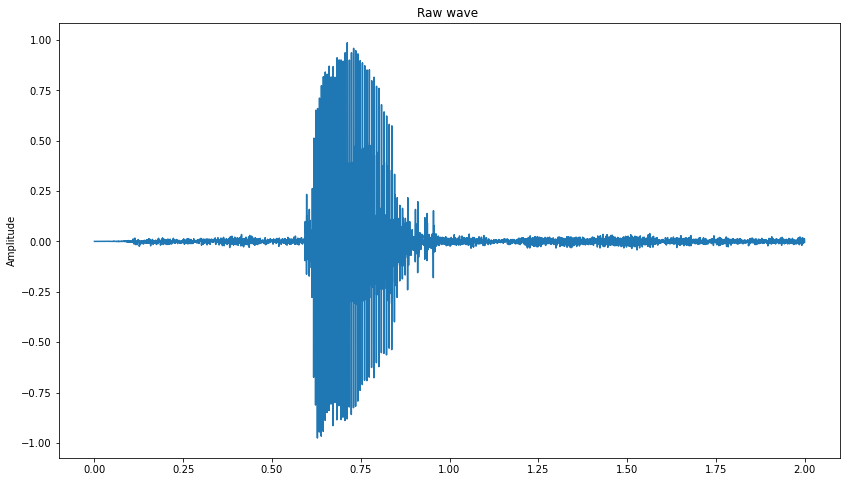

In [ ]:
plot_time_series(minority_data[0], sr)
Audio(minority_data[0], rate=sr)

In [ ]:


augment1 = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=1)
    # TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    # PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    # Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])
augment2 = Compose([
    # AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5)
    TimeStretch(min_rate=0.8, max_rate=1.25, p=1)
    # PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    # Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

augment3 = Compose([
    # AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5)
    # TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5)
    PitchShift(min_semitones=-4, max_semitones=4, p=1),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=1)
])

augment4 = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5)
])

# Generate 2 seconds of dummy audio for the sake of example
# samples = np.random.uniform(
#     low=-0.2, high=0.2, size=(32000,)).astype(np.float32)

# Augment/transform/perturb the audio data
augmented_sample1 = augment1(samples=minority_data, sample_rate=sr)
augmented_sample2 = augment2(samples=minority_data, sample_rate=sr)
augmented_sample3 = augment3(samples=minority_data, sample_rate=sr)
augmented_sample4 = augment4(samples=minority_data, sample_rate=sr)


In [ ]:
print(f"augmented_sample1.shape: {augmented_sample1.shape}")
print(f"augmented_sample2.shape: {augmented_sample2.shape}")
print(f"augmented_sample3.shape: {augmented_sample3.shape}")
print(f"augmented_sample4.shape: {augmented_sample4.shape}")


augmented_sample1.shape: (1830, 32000)
augmented_sample2.shape: (1830, 32000)
augmented_sample3.shape: (1830, 32000)
augmented_sample4.shape: (1830, 32000)


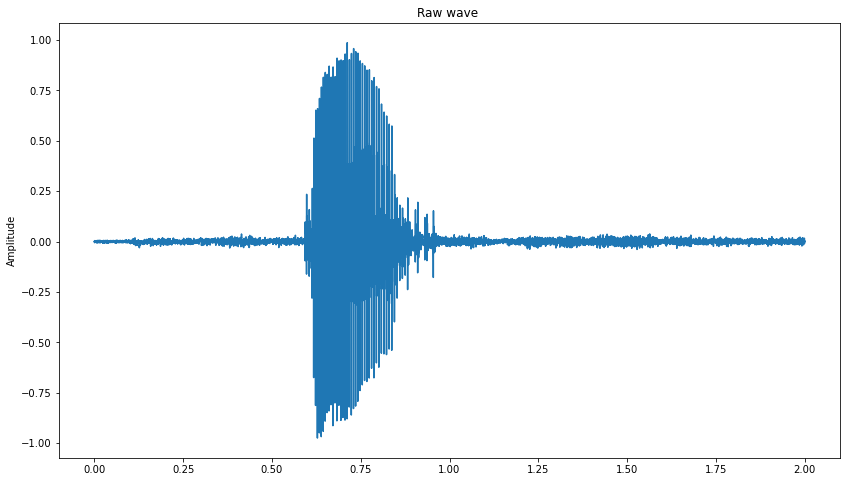

In [ ]:
Audio(augmented_sample1[0], rate=sr)
plot_time_series(augmented_sample1[0], sr)



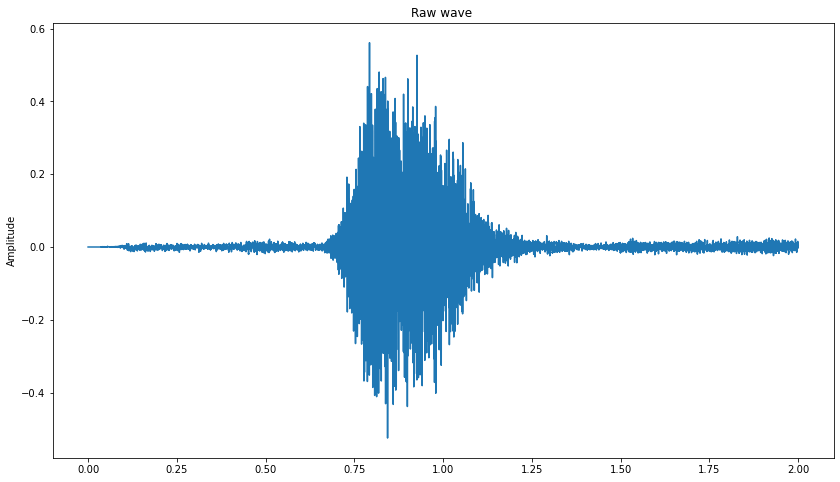

In [ ]:
plot_time_series(augmented_sample2[0], sr)
Audio(augmented_sample2[0], rate=sr)

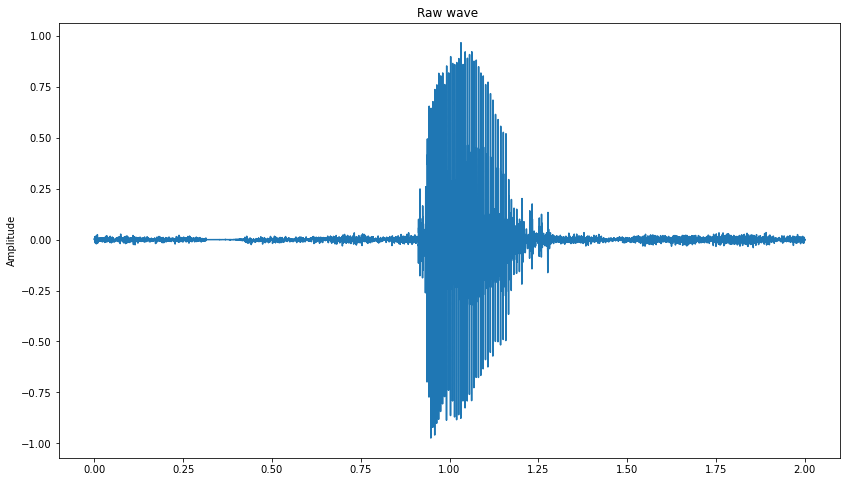

In [ ]:
plot_time_series(augmented_sample3[0], sr)
Audio(augmented_sample3[0], rate=sr)

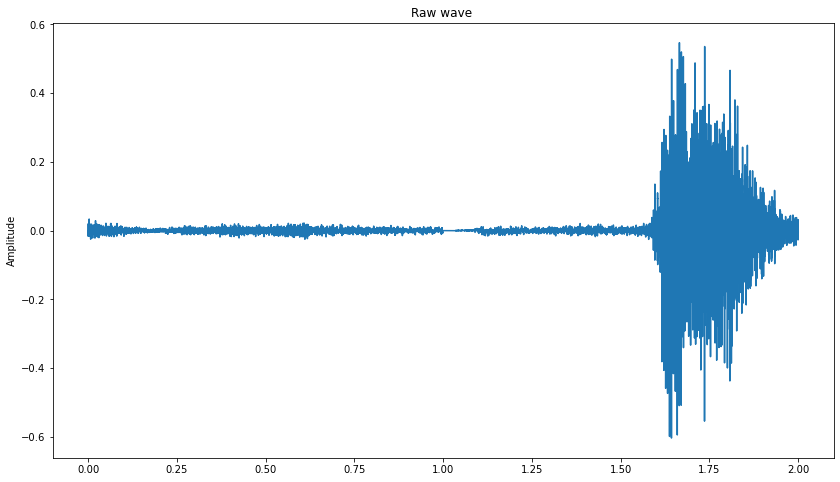

In [ ]:
plot_time_series(augmented_sample4[0], sr)
Audio(augmented_sample4[0], rate=sr)

In [ ]:
X_train = np.concatenate(
    [X_train, augmented_sample1, augmented_sample2, augmented_sample3, augmented_sample4], axis=0)
y_train = np.concatenate(
    [y_train, minority_label, minority_label, minority_label, minority_label], axis=0)
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")



X_train.shape: (9150, 32000)
y_train.shape: (9150,)


## Random train

In [19]:
order = np.arange(len(y_train))
np.random.seed(SEED)
np.random.shuffle(order)
X_train = X_train[order]
y_train = y_train[order]
X_train.shape


(1084, 32000)

## spectrogram

In [15]:
def make_spectrogram(audioData):
    spectrogram_data = []
    # An integer scalar Tensor. The window length in samples.
    frame_length = 255
    # An integer scalar Tensor. The number of samples to step.
    frame_step = 128
    # An integer scalar Tensor. The size of the FFT to apply.
    for i in range(len(audioData)):
        spectrogram = librosa.stft(
            audioData[i], hop_length=frame_step, win_length=frame_length)
        spectrogram = np.abs(spectrogram)
        spectrogram = np.power(spectrogram, 0.5)
        means = np.mean(spectrogram, 0, keepdims=True)
        stddevs = np.std(spectrogram, 0, keepdims=True)
        spectrogram = (spectrogram - means) / (stddevs + 1e-10)
        
        spectrogram_data.append(spectrogram)
    spectrogram_data = np.asarray(spectrogram_data)
    return spectrogram_data


X_train = make_spectrogram(X_train)
X_test = make_spectrogram(X_test)


In [16]:
print("Train:")
print(f"X: {X_train.shape}")
print(f"y: {y_train.shape}")
print(f"worcard:{wordcard_train.shape}")
print("Test:")
print(f"X: {X_test.shape}")
print(f"y: {y_test.shape}")
print(f"worcard:{wordcard_test.shape}")


Train:
X: (1084, 1025, 251)
y: (1084,)
worcard:(1084,)
Test:
X: (272, 1025, 251)
y: (272,)
worcard:(272,)


In [17]:
def make_pairs(x, y, wordcard):
    dict_indices = dict()
    for i in classes:
        dict_indices[i] = np.where(y == i)[0]
    

    pairs = []
    labels = []
    label2_list = []
    countMax = 5*len(x)
    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        wordcard1 = wordcard[idx1]
        idx2 = random.choice(dict_indices[label1])
        count = 0
        ISBREAK = False
        while ((wordcard1 != wordcard[idx2]) | (idx2 == idx1)):
            idx2 = random.choice(dict_indices[label1])
            count = count + 1 

            if(count > countMax):
                ISBREAK = True
                # print("QAQ break")
                break
        if not ISBREAK:
            x2 = x[idx2]
            pairs += [[x1, x2]]
            labels += [1]
        
        label2_list = classes.copy()
        label2_list.remove(label1)
        
        while (label2_list):
            # add a non-matching example
            label2 = random.choice(label2_list)
            count = 0
            ISBREAK = False
            idx2 = random.choice(dict_indices[label2])
            while ((wordcard1 != wordcard[idx2]) | (idx2 == idx1)):
                idx2 = random.choice(dict_indices[label2])
                count = count + 1
                if(count > countMax):
                    ISBREAK = True
                    label2_list.remove(label2)
                    break
            if not ISBREAK:
                x2 = x[idx2]
                pairs += [[x1, x2]]
                labels += [0]
                break
    return np.array(pairs), np.array(labels).astype("float32")


# make train pairs
pairs_train, labels_train = make_pairs(X_train, y_train, wordcard_train)

# make test pairs
pairs_test, labels_test = make_pairs(X_test, y_test, wordcard_test)
print(pairs_train.shape)
print(pairs_test.shape)



(1893, 2, 1025, 251)
(398, 2, 1025, 251)


We get:

**pairs_train.shape = (x, 2, 1025, 251)**

- We have x pairs
- Each pair contains 2 spectrograms 
- Each image has shape `(1025, 251)`

In [18]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]


In [19]:
x_test_1 = pairs_test[:, 0]  # x_test_1.shape = (20000, 28, 28)
x_test_2 = pairs_test[:, 1]


In [20]:

def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.pcolormesh(
            tf.concat([pairs[i][0], pairs[i][1]], axis=1))
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()


2022-10-02 20:51:53.840123: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-02 20:51:54.451045: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30975 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:dc:00.0, compute capability: 7.0


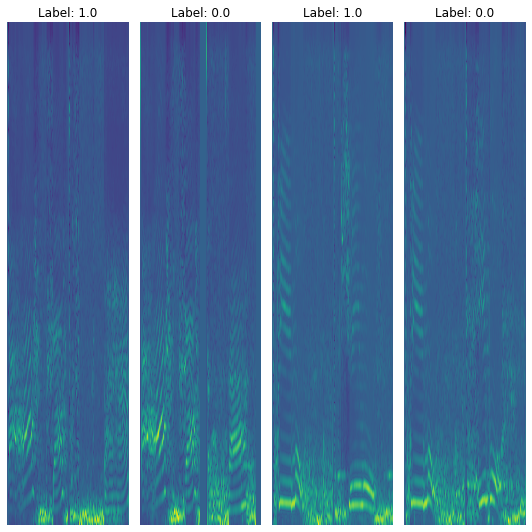

In [21]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)


## Hyperparameters

In [23]:
epochs = 50
batch_size = 128
margin = 1  # Margin for constrastive loss.


## Define the model

There are be two input layers, each leading to its own network, which
produces embeddings. A `Lambda` layer then merges them using an
[Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) and the
merged output is fed to the final network.

In [27]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((1025, 251, 1))
x = layers.Resizing(256, 256)(input)

x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(64, 3, activation='relu')(x)

# x = layers.Conv2D(
#     filters=32,
#     kernel_size=[17, 7],
#     use_bias=False,
#     strides=[2, 2],
#     name="conv_1",
#     activation='relu',
# )(input)

# # Convolution layer 2
# x = layers.Conv2D(
#     filters=32,
#     kernel_size=[11, 7],
#     strides=[2, 1],
#     use_bias=False,
#     name="conv_2",
#     activation='relu',
# )(x)
# x = layers.BatchNormalization(name="conv_2_bn")(x)
# x = layers.ReLU(name="conv_2_relu")(x)
# x = layers.Conv2D(32, 5, activation='relu')(x)
x = layers.MaxPooling2D()(x)
# x = layers.Dropout(0.25)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((1025, 251, 1))
input_2 = layers.Input((1025, 251, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)


## Define the constrastive Loss

In [28]:

def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


In [29]:
siamese.compile(loss=loss(margin=margin),
                optimizer="Adam", metrics=["accuracy"])
siamese.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1025, 251,   0           []                               
                                1)]                                                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1025, 251,   0           []                               
                                1)]                                                               
                                                                                                  
 model (Functional)             (None, 128)          130075136   ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

## Train the model

In [30]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_test_1, x_test_2], labels_test),
    batch_size=batch_size,
    epochs=epochs,
)


Epoch 1/50


2022-10-02 20:53:20.537296: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1780] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).
2022-10-02 20:53:21.353337: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fdaf401ba00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-10-02 20:53:21.353383: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-10-02 20:53:21.381515: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env

15/15 [==============================] - 27s 640ms/step - loss: 0.3061 - accuracy: 0.5151 - val_loss: 0.4576 - val_accuracy: 0.4271
Epoch 2/50
15/15 [==============================] - 20s 1s/step - loss: 0.2959 - accuracy: 0.5198 - val_loss: 0.4045 - val_accuracy: 0.4673
Epoch 3/50
15/15 [==============================] - 5s 333ms/step - loss: 0.2889 - accuracy: 0.5325 - val_loss: 0.3485 - val_accuracy: 0.4623
Epoch 4/50
15/15 [==============================] - 5s 334ms/step - loss: 0.2804 - accuracy: 0.5504 - val_loss: 0.3199 - val_accuracy: 0.4573
Epoch 5/50
15/15 [==============================] - 5s 337ms/step - loss: 0.2756 - accuracy: 0.5489 - val_loss: 0.2839 - val_accuracy: 0.5126
Epoch 6/50
15/15 [==============================] - 5s 334ms/step - loss: 0.2771 - accuracy: 0.5415 - val_loss: 0.2914 - val_accuracy: 0.5327
Epoch 7/50
15/15 [==============================] - 5s 341ms/step - loss: 0.2667 - accuracy: 0.5409 - val_loss: 0.2682 - val_accuracy: 0.5804
Epoch 8/50
15/15 [

## Visualize results

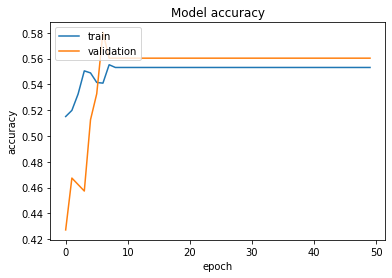

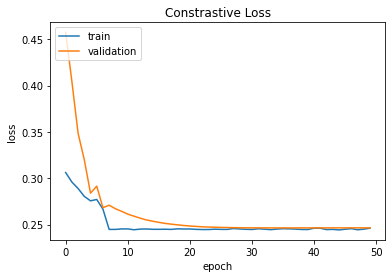

In [31]:

def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")


## Evaluate the model

In [32]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)


13/13 [==============================] - 3s 198ms/step - loss: 0.2464 - accuracy: 0.5603
test loss, test acc: [0.24643297493457794, 0.5603014826774597]


## Visualize the predictions

In [ ]:
predictions = siamese.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=3,
          predictions=predictions, test=True)
